In [31]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp
np.random.seed(123)

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "results/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
# #columns to normalise:
# with open(_FOLDER+"columns_to_normalise.txt", 'r') as f:
#     columns_to_normalise = [line.rstrip('\n') for line in f]
# # *****************************************

with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

In [32]:
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()
  
data_set = "Dataset 4" 
X_columns = X_feat_dict[data_set]
scaler = MinMaxScaler().fit(train_drug[X_columns])
Xtrain_drug = scaler.transform(train_drug[X_columns])
index_std_zero = Xtrain_drug.std(0)!=0
Xtrain_drug = Xtrain_drug[:,index_std_zero]
Xtest_drug = scaler.transform(test_drug[X_columns])
Xtest_drug = Xtest_drug[:,index_std_zero]

y_train_drug = train_drug["norm_cells_"+str(1)].values
y_test_drug =  test_drug["norm_cells_"+str(1)].values
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,train_drug["norm_cells_"+str(i)].values))
    y_test_drug = np.concatenate((y_test_drug,test_drug["norm_cells_"+str(i)].values))
    

(21709,)


In [33]:
#Xnew = Xtrain_drug[:,Xtrain_drug.std(0)!=0]
#y_train_drug.shape
#train_drug[train_drug.columns[10:30]]
#train_drug[["param_1","param_2","param_3","param_4"]]
#Xnew.shape
#plt.plot(Xtrain_drug.std(0))

In [34]:
### Training data for the GP ###
output_dim = 9
N_per_out = Xtrain_drug.shape[0]
aux_label_outputs = np.tile(np.arange(0,output_dim),(N_per_out,1)).T.reshape(-1) #Create labels for X
Xtrain = np.tile(Xtrain_drug,(output_dim,1))  #Here replicate (10,1) due to having ten outputs.
Xtrain = np.concatenate((Xtrain,aux_label_outputs[:,None]),axis=1)
Ytrain = np.concatenate((y_train_drug[:,None],aux_label_outputs[:,None]),axis=1)

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
aux_label_outputs_test = np.tile(np.arange(0,output_dim),(N_per_out_test,1)).T.reshape(-1) #Create labels for X
Xtest = np.tile(Xtest_drug,(output_dim,1))  #Here replicate (10,1) due to having ten outputs.
Xtest= np.concatenate((Xtest,aux_label_outputs_test[:,None]),axis=1)
Ytest = np.concatenate((y_test_drug[:,None],aux_label_outputs_test[:,None]),axis=1)

In [35]:
#Xtrain.shape
#aux_label_outputs.shape
#aux_label_outputs[:,None].shape
#y_train_drug.shape
#Ytrain.shape
#aux_label_outputs_test.shape
X_aug = Xtrain.copy()
Y_aug_NoStd = Ytrain.copy()
Y_aug = Ytrain.copy()

In [36]:
"Here we standardise the output"
#import matplotlib.pyplot as plt
ymean = Y_aug_NoStd.mean(0)
ystd = Y_aug_NoStd.std(0)
ymean.shape
standard = False
if standard:
    #Y_aug[:,0] = (Y_aug_NoStd[:,0]-ymean[0])/ystd[0]
    mymean= []
    mystd = []
    for i in range(output_dim):
        mymean.append(np.mean(Y_aug[Y_aug[:,1]==i,0]))
        mystd.append(np.std(Y_aug[Y_aug[:,1]==i,0]))
        Y_aug[Y_aug[:,1]==i,0]=(Y_aug[Y_aug[:,1]==i,0]-mymean[i])/mystd[i]
else:
    Y_aug = Y_aug_NoStd.copy()     
    mymean= [0]*output_dim
    mystd = [1.0]*output_dim
#plt.plot(X_aug[:,66])
#X_aug.shape
#X_aug.mean(0).shape
#plt.plot(X_aug.mean(0))

In [37]:
#np.clip?
#[0]*10
#np.mean(Y_aug[Y_aug[:,1]==3,0])

In [38]:
np.isnan(Xtrain).sum()

0

In [39]:
"Create a K-fold for cross-validation"
from sklearn.model_selection import KFold, cross_val_score
Xind = np.arange(N_per_out)
k_fold = KFold(n_splits=4,shuffle=True,random_state=0)

In [40]:
import sys
from time import time
import numpy as np
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import gpflow as gpf
from gpflow.kernels import SquaredExponential as SE
from gpflow.kernels import Matern12 as M12
from gpflow.kernels import Matern32 as M32
from gpflow.kernels import Matern52 as M52
from gpflow.kernels import Linear as Lin
from gpflow.kernels import Constant as Cons
from gpflow.likelihoods import Gaussian
from gpflow.likelihoods import Beta
from gpflow.likelihoods import Gamma
from gpflow.utilities import set_trainable
from gpflow.inducing_variables import (InducingPoints,SeparateIndependentInducingVariables,SharedIndependentInducingVariables)
from gpflow.optimizers import NaturalGradient
sys.path.append('../mowp-master/mowp/')
from kernels import LMC, KernelPrior
from models import CoregionSVGP
from likelihoods import CoregionSwitchedLikelihood
from utils import gen_data, plot_gp
tf.random.set_seed(0)
plt.rcParams.update({'font.size': 20})

In [41]:
def MSE_metric(Y_true,Y_approx):
    my_MSE = np.mean((Y_true-Y_approx)**2)  
    return my_MSE

def sigmoid_4_param(x,x0,L,k,d):
    y = 1/ (L + np.exp(-k*(x-x0))) + d
    return y

def predict_Y_Approx_S(Y_pred,x):
    Nobs = Y_pred[0].shape[0]//4  #due to having 4 outputs 
    Ndoses = x.shape[0]
    Y_Approx_S = np.zeros((Nobs,Ndoses))
    for indy in range(Nobs):
        Y_pred_m = Y_pred[0].numpy()
        Y_pred_v = Y_pred[1].numpy()
        p1_stoch = (np.random.normal(Y_pred_m[indy], 0.0*np.sqrt(Y_pred_v[indy]), 10000))[:,None]
        p2_stoch = (np.random.normal(Y_pred_m[indy+Nobs], 0.0*np.sqrt(Y_pred_v[indy+Nobs]), 10000))[:,None]
        p3_stoch = (np.random.normal(Y_pred_m[indy+2*Nobs], 0.0*np.sqrt(Y_pred_v[indy+2*Nobs]), 10000))[:,None]
        p4_stoch = (np.random.normal(Y_pred_m[indy+3*Nobs], 0.0*np.sqrt(Y_pred_v[indy+3*Nobs]), 10000))[:,None]

        y_shape_S_pred_stoch = sigmoid_4_param(x,p1_stoch,p2_stoch,p3_stoch,p4_stoch)
        Y_Approx_S[indy,:] = y_shape_S_pred_stoch.mean(0)
    return Y_Approx_S

In [59]:
tf.random.set_seed(0)
scores = []
output_dim = output_dim
N = X_aug.shape[0]//output_dim #200
L = 5   #number of latent GPs
minibatch_size = 100
seed = 22
print('Seed:', seed)
np.random.seed(seed)
# Inducing Variables
Zs = []
num_inducing = 100 #200
for i in range(L):
    minis = X_aug.min(0)[0:-1]  #We do not include the last feature due to being the label
    maxis = X_aug.max(0)[0:-1]  #We do not include the last feature due to being the label
    Dim = X_aug.shape[1]-1   #Substract the last feature due to being the label
    Z = np.linspace(minis[0], maxis[0], num_inducing).reshape(1, -1)
    for i in range(Dim - 1):
        Zaux = np.linspace(minis[i + 1], maxis[i + 1], num_inducing)
        Z = np.concatenate((Z, Zaux[np.random.permutation(num_inducing)].reshape(1, -1)), axis=0)
    Zs.append(1.0 * Z.T)

models = []
MSE_all = []
Median_R2 = []
for train_id, val_id in k_fold.split(Xind):
    
    # Generating Data
    #np.random.seed(seed)
    print(val_id)
    X_aug_train = np.concatenate((X_aug[train_id,:].copy(),X_aug[train_id+N,:].copy(),X_aug[train_id+2*N,:].copy(),X_aug[train_id+3*N,:].copy(),X_aug[train_id+4*N,:].copy(),X_aug[train_id+5*N,:].copy(),X_aug[train_id+6*N,:].copy(),X_aug[train_id+7*N,:].copy(),X_aug[train_id+8*N,:].copy()))
    Y_aug_train = np.concatenate((Y_aug[train_id,:].copy(),Y_aug[train_id+N,:].copy(),Y_aug[train_id+2*N,:].copy(),Y_aug[train_id+3*N,:].copy(),Y_aug[train_id+4*N,:].copy(),Y_aug[train_id+5*N,:].copy(),Y_aug[train_id+6*N,:].copy(),Y_aug[train_id+7*N,:].copy(),Y_aug[train_id+8*N,:].copy()))
    
    X_aug_val = np.concatenate((X_aug[val_id,:].copy(),X_aug[val_id+N,:].copy(),X_aug[val_id+2*N,:].copy(),X_aug[val_id+3*N,:].copy(),X_aug[val_id+4*N,:].copy(),X_aug[val_id+5*N,:].copy(),X_aug[val_id+6*N,:].copy(),X_aug[val_id+7*N,:].copy(),X_aug[val_id+8*N,:].copy(),))
    Y_aug_val = np.concatenate((Y_aug[val_id,:].copy(),Y_aug[val_id+N,:].copy(),Y_aug[val_id+2*N,:].copy(),Y_aug[val_id+3*N,:].copy(),Y_aug[val_id+4*N,:].copy(),Y_aug[val_id+5*N,:].copy(),Y_aug[val_id+6*N,:].copy(),Y_aug[val_id+7*N,:].copy(),Y_aug[val_id+8*N,:].copy(),))
    
    # Likelihoods
    #lik = CoregionSwitchedLikelihood([Gaussian(0.01), Gaussian(0.01), Gaussian(0.01)], [1, 1, 1])
    lik = CoregionSwitchedLikelihood([Gaussian(1)]*output_dim, [1]*output_dim)
    #lik = CoregionSwitchedLikelihood([Beta()]*output_dim, [1]*output_dim)
    
    #Zs = [np.random.uniform(0, 10, N // 3)[:, None] for _ in range(L)]
    iv_list = [InducingPoints(Z) for Z in Zs]
    
    #iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Zs[0]))
    
    iv = SeparateIndependentInducingVariables(iv_list)
    
  
    # create multi-output inducing variables from Z
    data = (X_aug_train, Y_aug_train)
    scal = 10*np.sqrt(Dim)  #use 10 with num_inducing=500 and minibatch = 500
    weight = 0.1
    #l_scale = scal*np.random.rand(Dim)
    #list_k_q = [SE(1.0,l_scale) + M32(1.0,l_scale) + Lin() + Cons() for i in range(L)]  # create the list of kernels for GPs u_q
    
    list_k_q = []
    split_dim = 10
    "here is Dim and Not Dim-1, I alredy substracted the -1 before"
    size_dims = (Dim)//split_dim
    for i in range(L):
        k = Cons(active_dims=list(np.arange(0,size_dims))) + Lin(active_dims=list(np.arange(0,size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))
        #k = SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))
        #print(list(np.arange(0,size_dims)))
        for i in range(1,split_dim):
            if i != (split_dim-1):
                k = k + Cons(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims))) + Lin(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
                #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
                #print(list(np.arange(size_dims*i,size_dims*i+size_dims)))
            else:
                k = k + Cons(active_dims=list(np.arange(size_dims*i,Dim))) + Lin(active_dims=list(np.arange(size_dims*i,Dim)))* M12(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))
                #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))
        list_k_q.append(k)
    
    kern = LMC(output_dim, list_k_q)
    for i in range(L):
        kern.coregs[i].W.assign(weight * np.random.rand(output_dim, 1))
    
    # initialize mean of variational posterior to be of shape MxL
    #q_mu = np.zeros((num_inducing, L))
    q_mu = 2*np.random.randn(num_inducing, L)
    # initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
    q_sqrt = np.repeat(np.eye(num_inducing)[None, ...], L, axis=0) * 1.0
    
    m = CoregionSVGP(kern, lik, iv, q_mu=q_mu, q_sqrt=q_sqrt, num_latent_gps=L, whiten=True)
#     for i in range(L):
#         for j in range(4):
#             set_trainable(m.kernel.kernels[i].kernels[j].variance, False)
        
#     import pickle
#     path_to_load = '/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/GP_results_HPC/New/seed1010/'
#     with open(path_to_load+'mod_'+'l'+str(L)+'b'+str(minibatch_size)+'m'+str(num_inducing)+'w'+str(weight)+'s'+str(scal)+'.pickle', 'rb') as f:
#         params_model_loaded = pickle.load(f)

#     gpf.utilities.multiple_assign(m, params_model_loaded)
    
    #set_trainable(m.likelihood, False)
    
    #natgrad = NaturalGradient(0.1)
    #set_trainable(m.q_mu, False)
    #set_trainable(m.q_sqrt, False)
    
    #set_trainable(m.kernel, False)
        
    #set_trainable(m.inducing_variable, False)
    Nval = X_aug_val.shape[0]//output_dim
    train_dataset = tf.data.Dataset.from_tensor_slices(data).repeat().shuffle(N-Nval)
    train_iter = iter(train_dataset.batch(minibatch_size))

    def run_adam(model, iterations):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action
        logf = []
        train_iter = iter(train_dataset.batch(minibatch_size))
        training_loss = model.training_loss_closure(train_iter, compile=True)
        optimizer1 = tf.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        #optimizer2 = tf.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
        @tf.function
        def optimization_step():
            optimizer1.minimize(training_loss, model.trainable_variables)
#             set_trainable(m.q_mu, False)
#             set_trainable(m.q_sqrt, False)
#             set_trainable(model.inducing_variable, False)
#             set_trainable(m.likelihood, True)
#             set_trainable(m.kernel, True)
#             optimizer1.minimize(training_loss, model.trainable_variables)
#             set_trainable(model.inducing_variable, True)
#             set_trainable(m.likelihood, False)
#             set_trainable(m.kernel, False)
#             set_trainable(m.q_mu, True)
#             set_trainable(m.q_sqrt, True)
#             optimizer2.minimize(training_loss, model.trainable_variables)
            #natgrad.minimize(training_loss, [(m.q_mu, m.q_sqrt)])

        for step in range(iterations):
            if step % 10 == 0:
                elbo = -training_loss().numpy()
                if step == int(iterations*0.000):
                    pass
                    #set_trainable(model.inducing_variable, True)
                    #set_trainable(m.likelihood, True)
                    #set_trainable(m.kernel, True)

                if step % 100 == 0:
                    print(f"At iter {step}: ELBO = {elbo}")
                logf.append(elbo)
            optimization_step()
        return logf

    maxiter = 5000
    logf = run_adam(m, maxiter)
      
    #x_doses = np.linspace(0,1, 20)
    
    #Y_True_S_val = sigmoid_4_param(np.tile(x_doses.T,(Nval,1)),(mystd[0]*Y_aug_val[0:Nval,0]+mymean[0])[:,None],(mystd[1]*Y_aug_val[Nval:2*Nval,0]+mymean[1])[:,None],(mystd[2]*Y_aug_val[2*Nval:3*Nval,0]+mymean[2])[:,None],(mystd[3]*Y_aug_val[3*Nval:4*Nval,0]+mymean[3])[:,None])
    Y_approx_val,_ = m.predict_y(X_aug_val)  #Here we are just using the mean for the predictions not including std
    Y_approx_val=Y_approx_val.numpy()

    #Y_Approx_S_val = sigmoid_4_param(np.tile(x_doses.T,(Nval,1)),(mystd[0]*Y_approx_val[0:Nval,0]+mymean[0])[:,None],(mystd[1]*Y_approx_val[Nval:2*Nval,0]+mymean[1])[:,None],(mystd[2]*Y_approx_val[2*Nval:3*Nval,0]+mymean[2])[:,None],(mystd[3]*Y_approx_val[3*Nval:4*Nval,0]+mymean[3])[:,None])
    #r2_scr = r2_score(Y_True_S_val.T, Y_Approx_S_val.T, multioutput='raw_values')[:,None]

    #Median_R2.append(np.median(r2_scr))
    MSE_res = MSE_metric(Y_aug_val,Y_approx_val)
    MSE_all.append(MSE_res)
    models.append(m)
    break
    
#     plt.figure(0)
#     plt.plot(np.arange(maxiter)[::10], logf)
#     plt.xlabel("iteration")
#     _ = plt.ylabel("ELBO")

Seed: 22
[    1     7     8 ... 21705 21706 21707]
At iter 0: ELBO = -1157.9461732438533
At iter 100: ELBO = -998.1158381312507
At iter 200: ELBO = -924.4699338679409
At iter 300: ELBO = -855.1532850091542
At iter 400: ELBO = -792.1913464691524
At iter 500: ELBO = -733.551662868447
At iter 600: ELBO = -682.8870435595843
At iter 700: ELBO = -629.65282980091
At iter 800: ELBO = -582.3921352811615
At iter 900: ELBO = -538.705953930121
At iter 1000: ELBO = -494.52046026977223
At iter 1100: ELBO = -454.93436650044544
At iter 1200: ELBO = -418.46965914822977
At iter 1300: ELBO = -385.2609574352885
At iter 1400: ELBO = -354.65430132404657
At iter 1500: ELBO = -325.0955246612802
At iter 1600: ELBO = -301.0746708296225
At iter 1700: ELBO = -279.4919839586046
At iter 1800: ELBO = -261.5501865727611
At iter 1900: ELBO = -238.19350445143667
At iter 2000: ELBO = -225.82078659795226
At iter 2100: ELBO = -196.56309282646743
At iter 2200: ELBO = -182.23861395223457
At iter 2300: ELBO = -154.0506012085

In [60]:
#X_aug_train[Y_aug_train[:,1]==0,:]
#plt.figure(0,figsize=[20,500])
#plt.imshow(X_aug_train[Y_aug_train[:,1]==0,:])
#plt.hist(Y_aug_train[Y_aug_train[:,1]==2,0],20)

MSE:  10.091922962646516


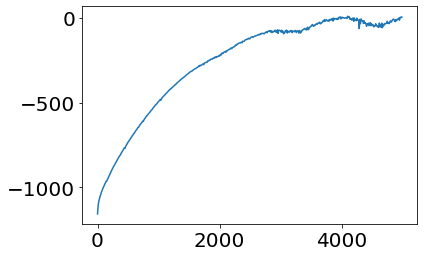

In [61]:
print("MSE: ",MSE_res)
#print("Median R2:",Median_R2)
#print("Mean R2",r2_scr.mean())

#r2_scr.mean()
#Y_Approx_S.shape0
#Y_True_S.shape0
#plt.plot(Y_Approx_S.T)
#plt.ylim([0,1])
#plt.plot(Y_Approx_S[6])
#plt.plot(Y_True_S[6])

plt.plot(np.arange(maxiter)[::10], logf)
#plt.plot(logf)

#plt.scatter(Y_True_S_val,Y_Approx_S_val)
#plt.scatter(Y_True_S_val,Y_True_S_val)
#plt.plot(x_doses,Y_True_S_val.T)
#optimizer = tf.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optimizer?
#m

In [62]:
#m
#MSE_all
#models[1]
#MSE_res
#Y_pred = models[0].predict_y(X_aug_val)
#Y_pred[1]

#set_trainable(m.likelihood, False)
    
#set_trainable(m.q_mu, False)

#set_trainable(m.kernel, False)

#set_trainable(m.inducing_variable, False)
#logf = run_adam(m, 10)
Y_pred = models[0].predict_y(X_aug_val)

In [63]:
#(mystd[0]*Y_aug_val[0:Nval,0]+mymean[0])[:,None].shape
#(mystd[0]*Y_approx_val[0:Nval,0]+mymean[0])[:,None].shape
#Y_Approx_S_val.shape
#Y_True_S_val.shape
#plt.plot(x_doses,Y_True_S_val.T)
#plt.plot(x_doses,Y_Approx_S_val.T)
#Y_pred[0].shape
#X_aug_val.shape
#Y_pred[0].shape
#Y_pred[0][Nval,0]
#plt.plot()

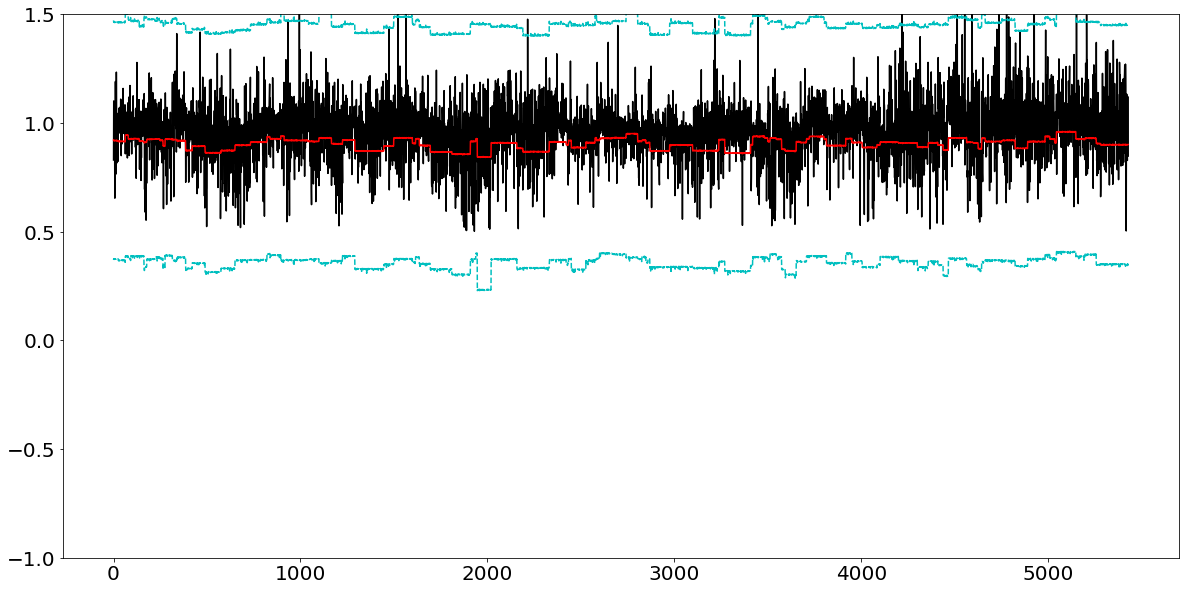

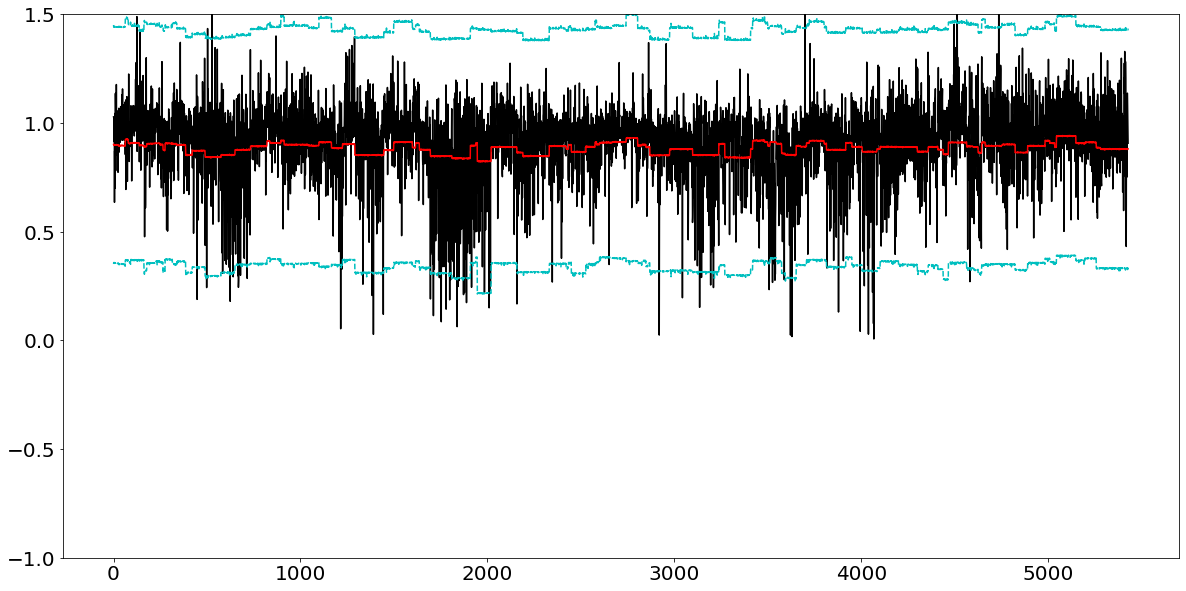

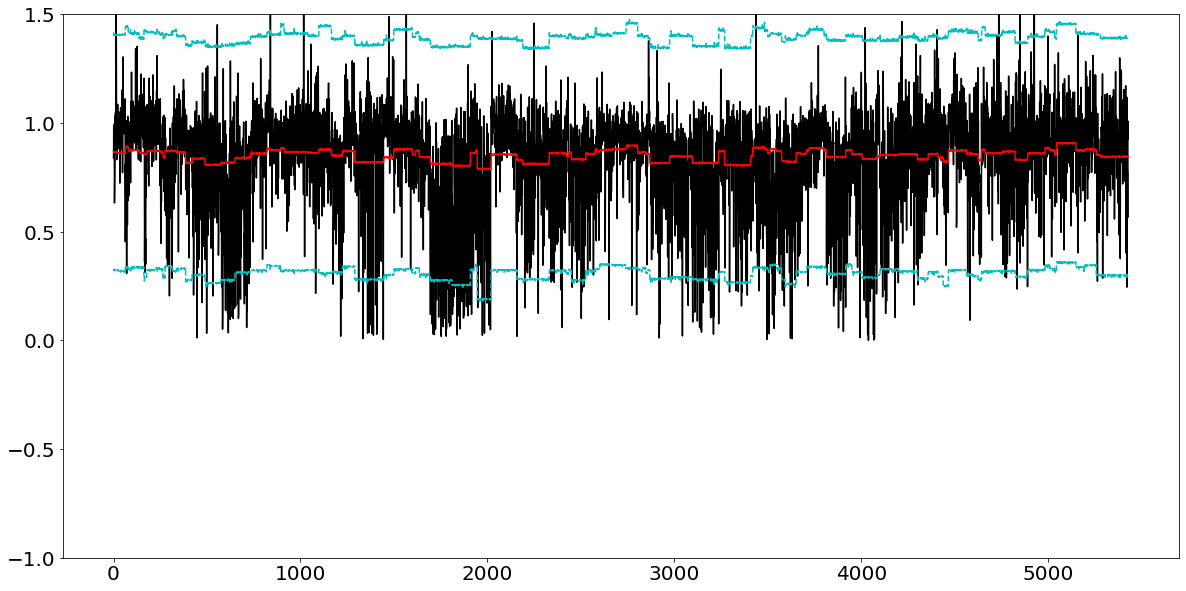

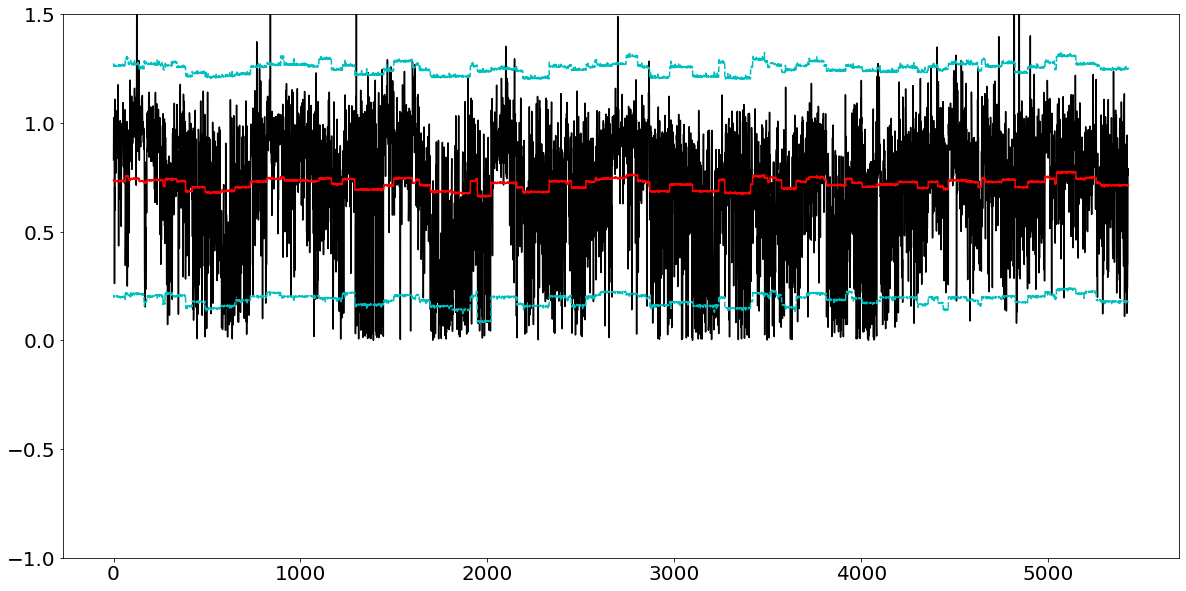

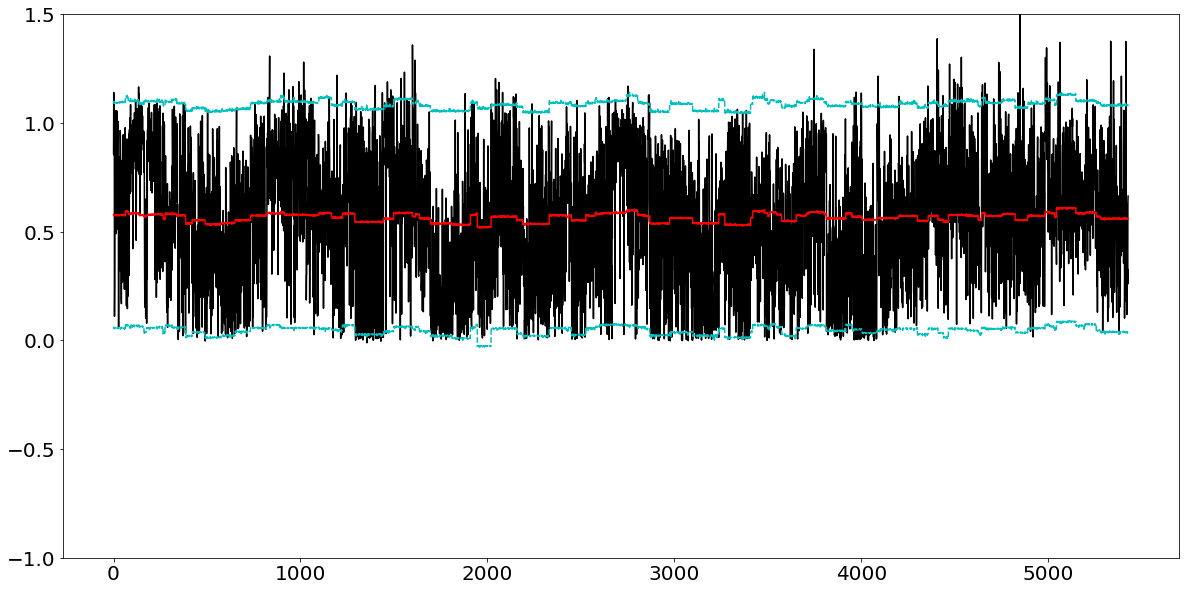

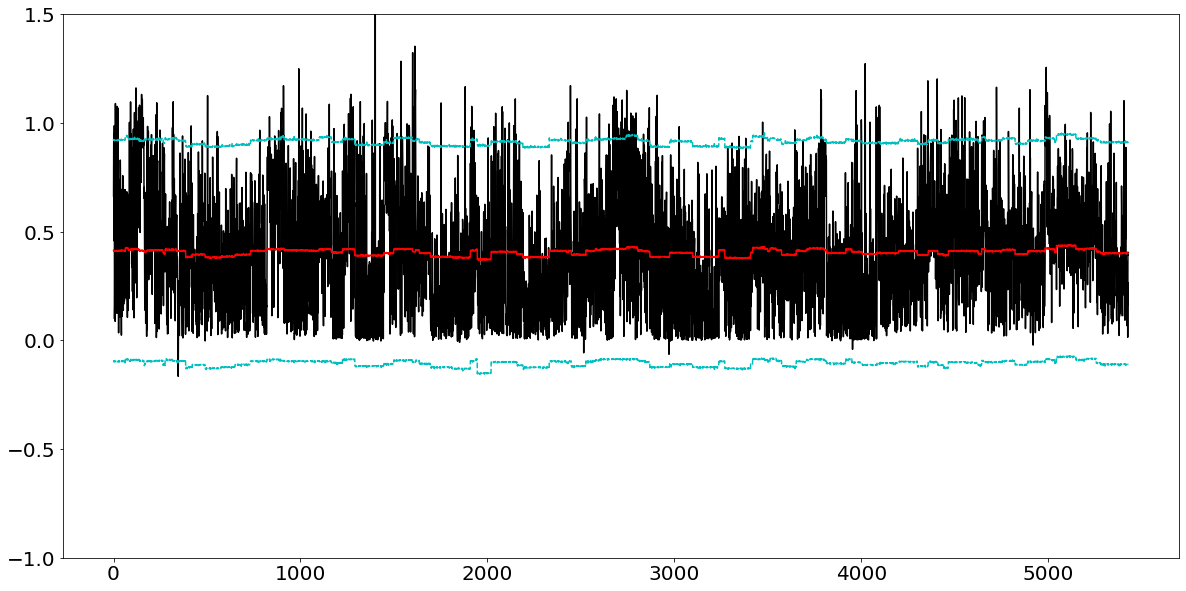

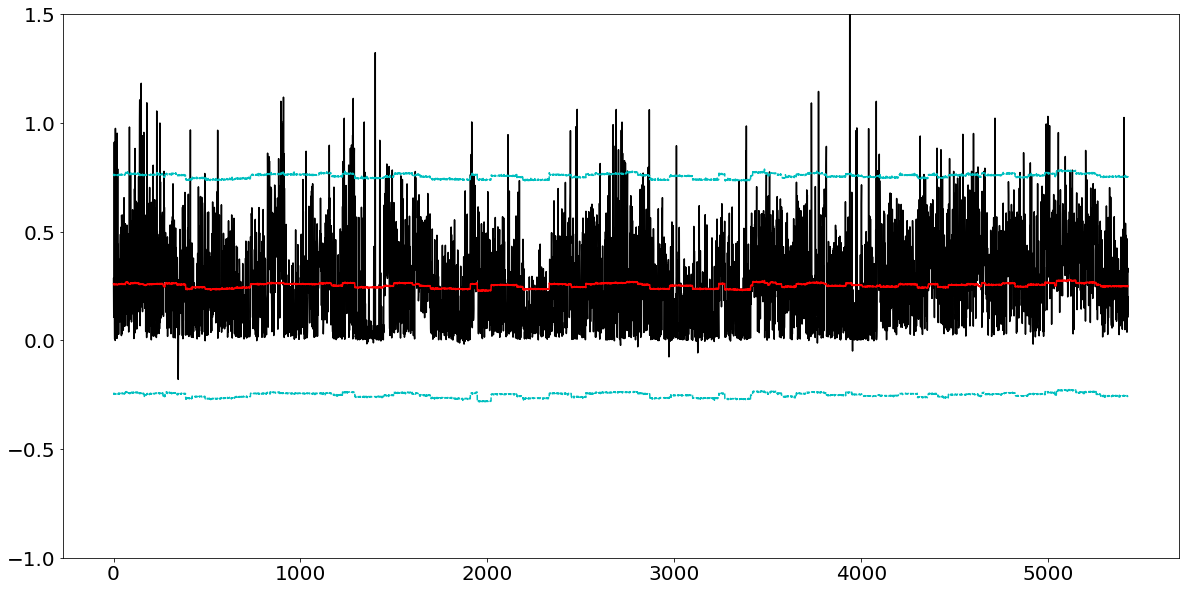

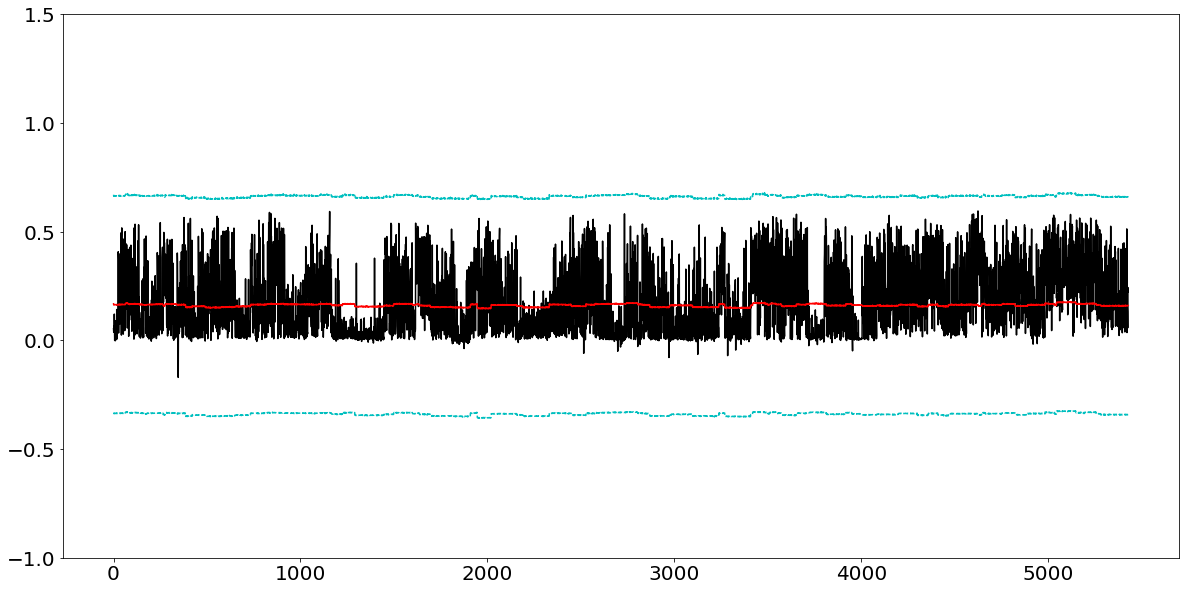

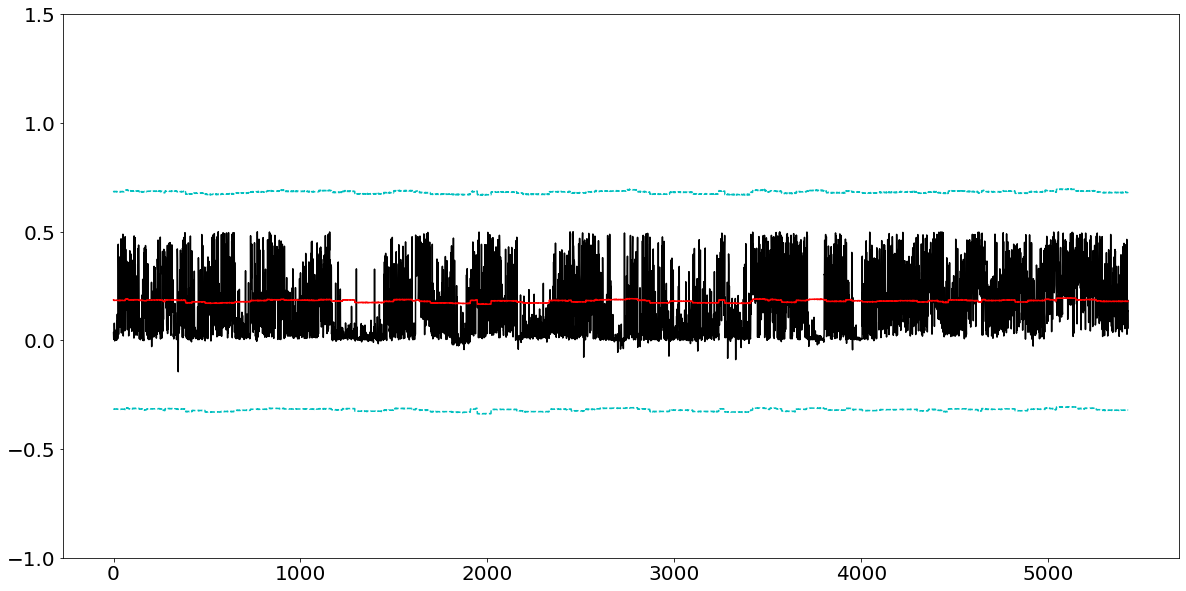

In [64]:
for i in range(0,output_dim):
    plt.figure(i,[20, 10])
    plt.plot(Y_aug_val[i*Nval:i*Nval+Nval,0],'black')
    plt.plot(Y_pred[0][i*Nval:i*Nval+Nval].numpy(),'r')
    plt.plot(Y_pred[0][i*Nval:i*Nval+Nval].numpy()+2*np.sqrt(Y_pred[1][i*Nval:i*Nval+Nval].numpy()),'c--')
    plt.plot(Y_pred[0][i*Nval:i*Nval+Nval].numpy()-2*np.sqrt(Y_pred[1][i*Nval:i*Nval+Nval].numpy()),'c--')
    plt.ylim([-1,1.5])


In [38]:
Y_pred2 = Y_pred[0].numpy()
#Y_pred2.shape
#ymean
indy = 350
#Y_aug[indy+2*N,0]*ystd[0]+ymean[0]
#Y_aug_NoStd[indy+2*N,0]
   
par1=Y_aug_val[indy,0]*mystd[0]+mymean[0]
par2=Y_aug_val[indy+Nval,0]*mystd[1]+mymean[1]
par3=Y_aug_val[indy+2*Nval,0]*mystd[2]+mymean[2]
par4=Y_aug_val[indy+3*Nval,0]*mystd[3]+mymean[3]
print(f"True: p1={par1}, p2={par2}, p3={par3}, p4={par4}")

par1=Y_pred2[indy,0]*mystd[0]+mymean[0]
par2=Y_pred2[indy+Nval,0]*mystd[1]+mymean[1]
par3=Y_pred2[indy+2*Nval,0]*mystd[2]+mymean[2]
par4=Y_pred2[indy+3*Nval,0]*mystd[3]+mymean[3]
print(f"Predited: p1={par1}, p2={par2}, p3={par3}, p4={par4}")


True: p1=1.0, p2=0.952683806, p3=0.966276174, p4=1.133833987
Predited: p1=0.9650208874826643, p2=0.9307626294314996, p3=0.9532752498102891, p4=0.9102489795697026


In [18]:
indy = 1086
#x_doses.shape
#Y_True_S_val.shape
plt.plot(x_doses,Y_Approx_S_val[indy,:],'r')

#plt.plot(x,y_shape_S_pred_m+2*y_shape_S_pred_std,'r--')
#plt.plot(x,y_shape_S_pred_m-2*y_shape_S_pred_std,'r--')

plt.plot(x_doses,Y_True_S_val[indy,:],'b')
plt.ylim([-0.5,1.2])

NameError: name 'x_doses' is not defined

In [203]:
y = np.random.rand(2,3)
y_fit = y.copy()
y_fit[1,1] = 0.51
r2_score(y.T, y_fit.T, multioutput='raw_values')[:,None]

array([[1.       ],
       [0.6687387]])

In [36]:
Y_aug[Y_aug[:,1]==1].std()

0.20482341742508953

In [60]:
#plt.plot(r2_scr)
#r2_scr.mean()
#np.median(r2_scr)

0.5019027908853366

In [52]:
#Y_aug_val[0:Nval,0]
Y_aug_val

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.56528913, 3.        ],
       [1.00839676, 3.        ],
       [0.92678866, 3.        ]])

In [34]:
m

name,class,transform,prior,trainable,shape,dtype,value
CoregionSVGP.kernel.coregs[0].W,Parameter,Identity,,True,"(9, 1)",float64,[[-2.41299909e-20...
CoregionSVGP.kernel.coregs[1].W,Parameter,Identity,,True,"(9, 1)",float64,[[-1.01765477e-20...
CoregionSVGP.kernel.coregs[2].W,Parameter,Identity,,True,"(9, 1)",float64,[[3.03701636e-07...
CoregionSVGP.kernel.coregs[3].W,Parameter,Identity,,True,"(9, 1)",float64,[[1.88327810e-64...
CoregionSVGP.kernel.coregs[4].W,Parameter,Identity,,True,"(9, 1)",float64,[[1.39025840e-24...
CoregionSVGP.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.698995458895675
CoregionSVGP.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(123,)",float64,"[0.80879092, 0.40113646, 0.47018136..."
CoregionSVGP.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.698995458895675
CoregionSVGP.kernel.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,"(123,)",float64,"[0.66442816, 0.03824736, 0.60878157..."
CoregionSVGP.kernel.kernels[0].kernels[2].variance,Parameter,Softplus,,True,(),float64,0.698995458895675
